## 온실가스 배출량

- Tier1 방법 사용(가장 간단) =  정박 시 연료소비량 X 온실가스 배출 계수

In [96]:
import pandas as pd

In [97]:
import pandas as pd
PATH  = '../data/'

df = pd.read_csv(PATH + '액체_모델용.csv')

In [98]:
df.columns

Index(['Datetime', 'ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', '호출부호',
       '입항일시', '출항일시', '접안_대기시간_분', '출항_대기시간_분', 'Service_Time_Start',
       'Service_Time_End', '계선장소_코드', '계선장소_숫자', '계선장소명', '선박용도',
       'Service_Time_분', '대기율', '총톤수', '재화중량톤수', '선박제원(총길이, m)', '선박제원(너비, m)',
       '만재흘수(m)', '깊이(m)', '길이1(m)', 'ETA_Minute', '풍속(m/s)', '풍향(deg)',
       'GUST풍속(m/s)', '현지기압(hPa)', '습도(%)', '기온(°C)', '수온(°C)', '최대파고(m)',
       '유의파고(m)', '평균파고(m)', '파주기(sec)', '파향(deg)', '액체화물'],
      dtype='object')

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51001 entries, 0 to 51000
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Datetime            51001 non-null  object 
 1   ETA_Year            51001 non-null  int64  
 2   ETA_Month           51001 non-null  int64  
 3   ETA_Day             51001 non-null  int64  
 4   ETA_Hour            51001 non-null  int64  
 5   호출부호                51001 non-null  object 
 6   입항일시                51001 non-null  object 
 7   출항일시                51001 non-null  object 
 8   접안_대기시간_분           51001 non-null  int64  
 9   출항_대기시간_분           51001 non-null  float64
 10  Service_Time_Start  51001 non-null  object 
 11  Service_Time_End    51001 non-null  object 
 12  계선장소_코드             51001 non-null  object 
 13  계선장소_숫자             51001 non-null  int64  
 14  계선장소명               51001 non-null  object 
 15  선박용도                51001 non-null  object 
 16  Serv

### 1. 정박 시 연료 소비량(대기)
- **연료소비계수(분)* 대기시간(분)* 보정계수(0.2)**

#### 연료소비계수

##### Gross Tonnage 구간화

In [100]:
bins = [0, 100, 500, 1000, 3000, 5000, 7000, 10000, 15000,20000,25000,30000,50000,60000,75000,100000, 100000000]
labels = ['≤ 100', '100~500', '500~1,000', '1,000~3,000', '3,000~5,000', '5,000~7,000', '7,000~10,000', '10,000~15,000',
         '15,000~20,000','20,000~25,000','25,000~30,000','30,000~50,000','50,000~60,000','60,000~75,000','75,000~100,000','Above 100,000']

df['Tonnage_group'] = pd.cut(df['총톤수'], bins=bins, labels=labels, right=False)

In [101]:
df['Tonnage_group'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 51001 entries, 0 to 51000
Series name: Tonnage_group
Non-Null Count  Dtype   
--------------  -----   
51001 non-null  category
dtypes: category(1)
memory usage: 50.6 KB


##### 구간별 연료소비계수 할당

- 연료 소비 계수(일) 할당

In [102]:
# 연료 소비 계수_딕셔너리
fuel_consumption_coefficients = {
    '≤ 100': 16.363,
    '100~500': 16.563,
    '500~1,000': 17.013,
    '1,000~3,000': 18.263,
    '3,000~5,000': 20.263,
    '5,000~7,000': 22.263,
    '7,000~10,000': 24.763,
    '10,000~15,000': 28.763,
    '15,000~20,000' : 33.763,
    '20,000~25,000' : 38.763,
    '25,000~30,000' : 43.763,
    '30,000~50,000' : 56.263,
    '50,000~60,000' : 71.263,
    '60,000~75,000' : 83.763,
    '75,000~100,000' : 103.763,
    'Above 100,000' : 116.263
}

# apply 적용
df['연료소비계수(일)'] = df['Tonnage_group'].apply(lambda x: fuel_consumption_coefficients[x])


In [103]:
df['연료소비계수(일)'].value_counts()

18.263     17700
16.563      9550
17.013      7553
20.263      6576
22.263      2194
24.763      2167
43.763      1858
56.263       977
28.763       687
38.763       603
33.763       570
83.763       353
71.263       103
103.763       51
116.263       48
16.363        11
Name: 연료소비계수(일), dtype: int64

- 연료소비계수(분)

In [104]:
df['연료소비계수(일)']

/Users/kimsinwoo/anaconda3/lib/python3.11/site-packages/IPython/lib/pretty.py:778: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0        17.013
1        18.263
2        18.263
3        18.263
4        18.263
          ...  
50996    17.013
50997    16.563
50998    18.263
50999    18.263
51000    16.563
Name: 연료소비계수(일), Length: 51001, dtype: category
Categories (16, float64): [16.363 < 16.563 < 17.013 < 18.263 ... 71.263 < 83.763 < 103.763 < 116.263]

In [105]:
df['연료소비계수(분)'] = df['연료소비계수(일)'].astype(float) / 24*60

- 정박 시 연료소비량

In [106]:
df['연료소비량(대기)'] =  df['연료소비계수(분)'] * df['접안_대기시간_분'] * 0.2

#### 온실가스 배출 계수

- 온실가스
    - MDO/MGO (해양 디젤 오일/해양 가스 오일) kg
        - CO (일산화탄소): 7.4 kg/톤 연료
        - NOx (질소 산화물): 78.5 kg/톤 연료

In [107]:
df['CO'] = df['연료소비량(대기)'] * 7.4
df['NOx'] = df['연료소비량(대기)'] * 78.5

In [108]:
df['CO'].mean()

41490.286814697756

In [109]:
df['NOx'].mean()

440133.44796672615

### 2. 대기오염물질 배출량 EDA

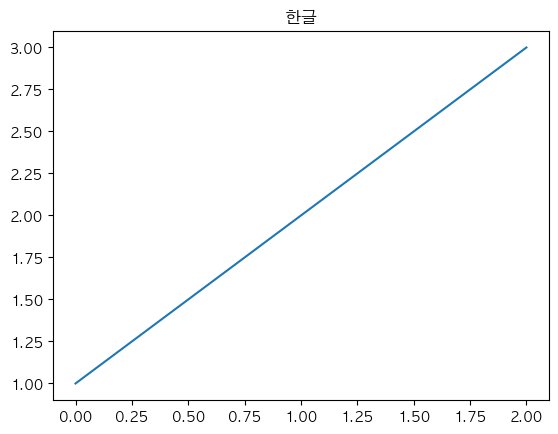

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", family="AppleGothic") # 라이브러리 불러오기와 함께 한번만 실행

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

#### 선박용도별

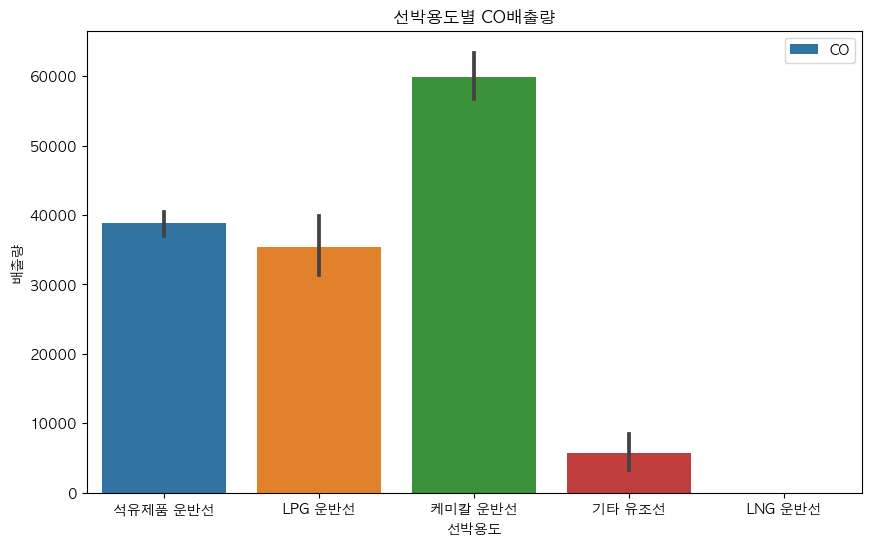

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='선박용도', y='CO', data=df, label='CO', ax=ax)
ax.set_title('선박용도별 CO배출량')
ax.set_xlabel('선박용도')
ax.set_ylabel('배출량')
ax.legend()
plt.show()

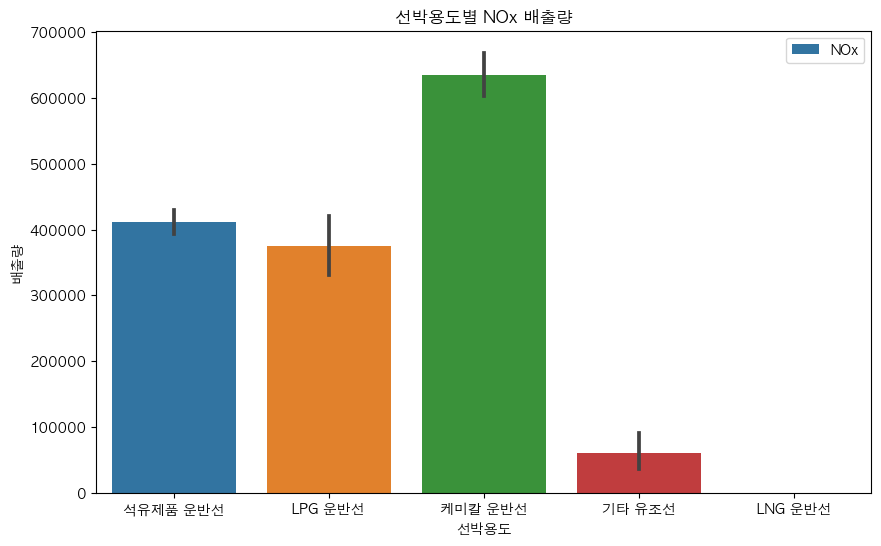

In [112]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='선박용도', y='NOx', data=df, label='NOx', ax=ax)
ax.set_title('선박용도별 NOx 배출량')
ax.set_xlabel('선박용도')
ax.set_ylabel('배출량')
ax.legend()
plt.show()

#### 선석별

In [113]:
temp = df.groupby('계선장소명')[['CO','NOx']].sum().reset_index()

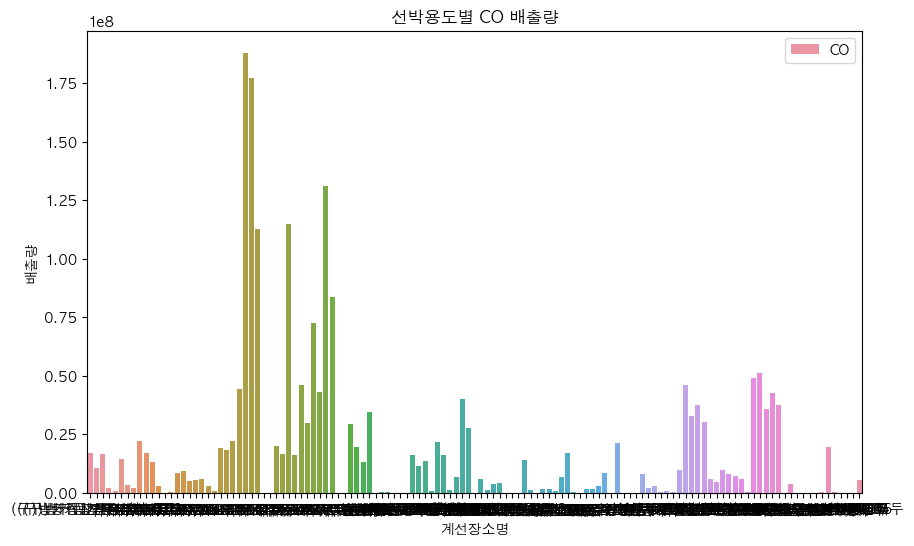

In [114]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='계선장소명', y='CO', data=temp, label='CO', ax=ax)
ax.set_title('선박용도별 CO 배출량')
ax.set_xlabel('계선장소명')
ax.set_ylabel('배출량')
ax.legend()
plt.show()

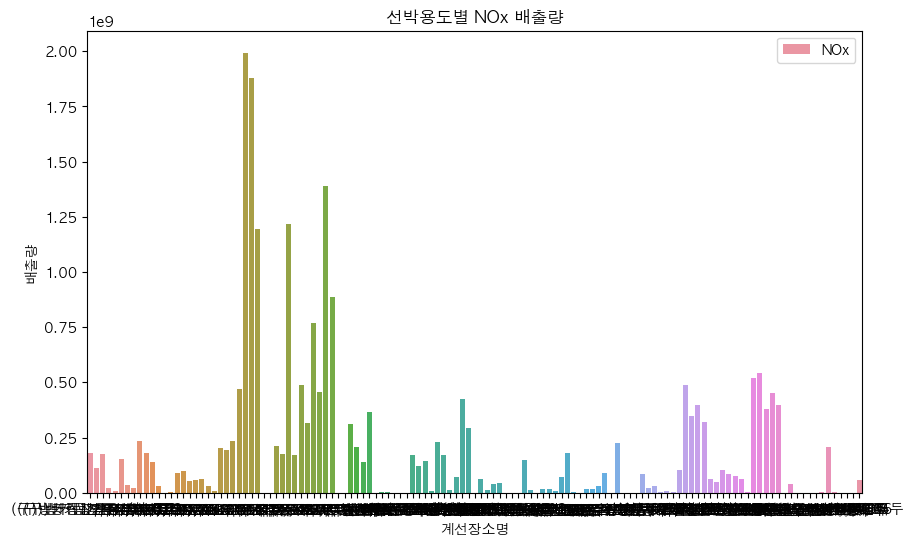

In [115]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='계선장소명', y='NOx', data=temp, label='NOx', ax=ax)
ax.set_title('선박용도별 NOx 배출량')
ax.set_xlabel('계선장소명')
ax.set_ylabel('배출량')
ax.legend()
plt.show()

### 3. 대기시간 감소 시 온실가스 감소량

In [116]:
df['접안_대기시간_분_5%'] = df['접안_대기시간_분']*0.95

In [117]:
df['연료소비량(대기)_5%'] =  df['연료소비계수(분)'] * df['접안_대기시간_분_5%'] * 0.2

In [138]:
df['연료소비량(대기)_1m'] =  df['연료소비계수(분)'] * (df['접안_대기시간_분']-1)*0.2

- ETA_Year 별 연료소비량 sum 구한 후, 연도별 평균

In [139]:
gas20 = df[df['ETA_Year'] == 2020]['연료소비량(대기)'].sum()
gas21 = df[df['ETA_Year'] == 2021]['연료소비량(대기)'].sum()
gas22 = df[df['ETA_Year'] == 2021]['연료소비량(대기)'].sum()

In [140]:
gas_mean = (gas20+gas21+gas22) / 3
gas_mean 

93378010.825

In [141]:
gas20_5 = df[df['ETA_Year'] == 2020]['연료소비량(대기)_5%'].sum()
gas21_5 = df[df['ETA_Year'] == 2021]['연료소비량(대기)_5%'].sum()
gas22_5 = df[df['ETA_Year'] == 2021]['연료소비량(대기)_5%'].sum()

In [147]:
gas_5_mean = (gas20_5+gas21_5+gas22_5) / 3
gas_5_mean

88709110.28375

In [143]:
round(gas_mean - gas_5_mean)

4668901

In [144]:
gas20_1 = df[df['ETA_Year'] == 2020]['연료소비량(대기)_1m'].sum()
gas21_1 = df[df['ETA_Year'] == 2021]['연료소비량(대기)_1m'].sum()
gas22_1 = df[df['ETA_Year'] == 2021]['연료소비량(대기)_1m'].sum()

In [145]:
gas_5_mean_1 = (gas20_1+gas21_1+gas22_1) / 3

In [146]:
round(gas_mean - gas_5_mean_1)

182993

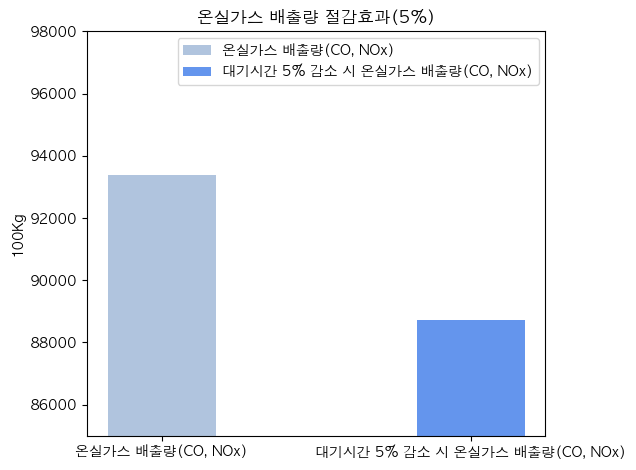

In [152]:
import matplotlib.pyplot as plt

data = (93378,88709)
labels = ['온실가스 배출량(CO, NOx)', '대기시간 5% 감소 시 온실가스 배출량(CO, NOx)']

bar_width = 0.35  # 각각의 막대 두께
bar_distance = 0.1  # 두 막대 간의 간격

fig, ax = plt.subplots()
bar1 = ax.bar(labels[0], data[0], color='lightsteelblue', width=bar_width, label=labels[0])
bar2 = ax.bar(labels[1], data[1], color='cornflowerblue', width=bar_width, label=labels[1])

ax.legend()
ax.set_ylabel('100Kg')
ax.set_title('온실가스 배출량 절감효과(5%)')

# Y 축 범위 설정
plt.ylim(85000,98000)  # 최소값은 0, 최대값은 데이터의 최대값의 1.1 배로 설정

fig.tight_layout()
plt.show()



In [64]:
df.to_csv(PATH + '액체_ver_2.csv', encoding = 'utf-8-sig', index = False)